# Diversipy Tutorial

This tutorial will walk you through using some of the main functionalities of the `Diversipy` package.

`Diversipy` leverages **_magnitude_** (i.e. effective size) as a **metric for measuring the diversity of metric spaces**.

This package provides the tools for measuring the intrinsic diversity of a space (via `MagArea`), as well as comparing diversity between spaces (via `MagDiff`).

### Tutorial overview:
1. Importing required packages and example datasets
3. Computing magnitude functions
4. Defining the evaluation interval
5. MagArea: An intrinsic measure of diversity
6. MagDiff: Evaluating differences in diversity across datasets

Additionally, the package supports several plotting functionalities, which will be demonstrated over the course of the tutorial.

#### Wanting to zoom in more?

Note that some of the underlying functionality of the Diversipy class is conducted by the Magnipy class, which is the main class that executes magnitude calculations. Please see the Magnipy tutorial to zoom in how these are conducted and additional applications of magnitude.

### 1. Importing Packages and Datasets
Before we begin, we must import the packages required for our functionality.

Please ensure that you have activated your virtual environment and installed the dependencies using poetry before this step (see **Dependencies** in the README).

In [1]:
# Import statements for external packages
from importlib import reload
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# Import from magnipy repo
import magnipy
reload(magnipy)
from magnipy.diversipy import Diversipy
from magnipy.utils.datasets import sample_points_gaussian, sample_points_gaussian_2, sample_points_square, hawkes_process
from magnipy.utils.plots import plot_points
from tutorial_data import *

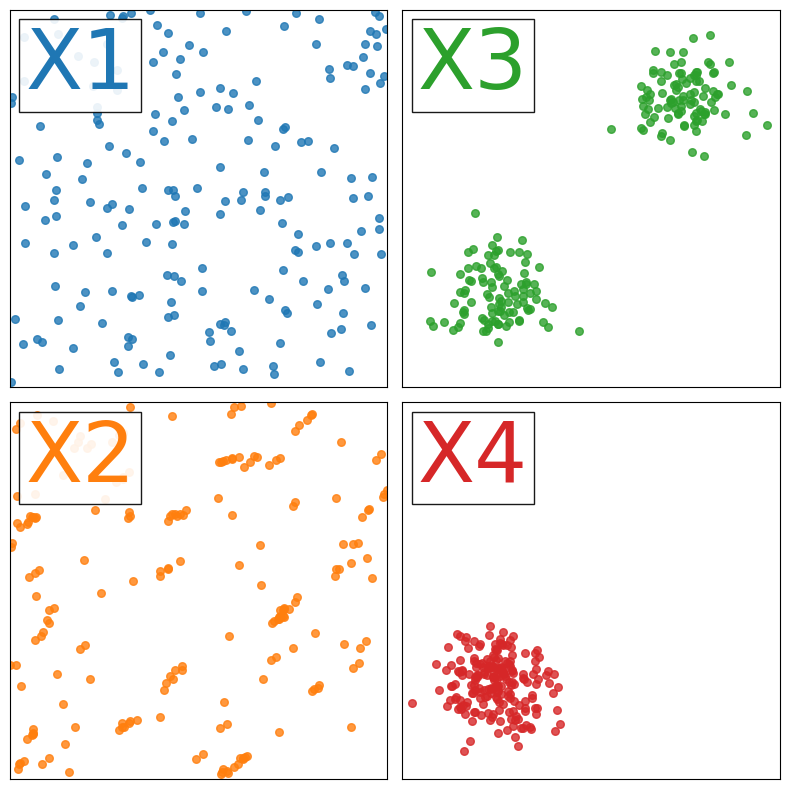

In [3]:
# Grab our example datasets
X1, X2, X3, X4 = get_Xs()
plot_spaces(X1, X2, X3, X4)


Intuitively, which of the above spaces would you consider the most _diverse_? The least diverse?

### How do we define diversity?

Diversity is a difficult notion to define precisely, but it is governed by several axioms that are widely agreed upon. Some of these include:  
- Diversity is maximised when points are completely distinct and minimised when all observations are identical.
- Including a new observation should not decrease diversity (monotonicity in observations).
- Including a duplicate observation should not change diversity (twin property).
- Diversity is summarised across multiple scales of (dis)similarity and thus
captures both local and global trends in the data manifold (i.e. should be multi-scale).

See the Appendix of our paper ([Metric Space Magnitude for Evaluating the Diversity of Latent Representations](https://arxiv.org/abs/2311.16054)) for further discussion of diveristy desiderata.

### How do we measure diversity?

We propose **magnitude** - which measures the effective number of distinct points at at a distance scale **t** - as a fitting solution for quantifying diversity.  

Magnitude functions instrinsically satisfy the above diversity axioms, and outperform other leading metrics (e.g. average similarity) that fail to accurately detect differences in diversity between datasets.

### 2. Computing Magnitude Functions

We initialize a Diversipy object with the spaces (**Xs**) that we want to compare. We can label our spaces via the **names** parameter.

There are many other parameters we can pass to the Diversipy object to customize its functionality. For example, the **metric** parameter allows you to choose which distance metric to use, with the default being Euclidean.

We will highlight a few of these parameters over the course of the tutorial. Please see `diversipy.py` for a complete list.

In [4]:
# Initializing Diversipy instance
Xs = [X1, X2, X3, X4]
names = ["X1 (Uniform)", "X2 (Slightly Clustered)", "X3 (Two Gaussians)", "X4 (One Gaussian)"]
div = Diversipy(Xs = Xs, names=names)

Common Evaluation Interval: 0.0 to 206.79


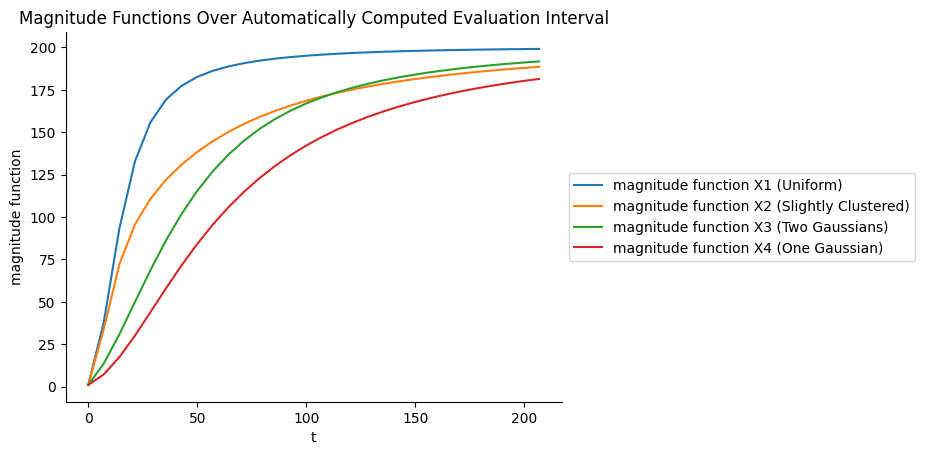

In [5]:
# Computing magnitude
mag_df, ts = div.get_magnitude_functions()
# Plotting magnitude functions
div.plot_magnitude_functions()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Magnitude Functions Over Automatically Computed Evaluation Interval")
# Showing common evaluation interval
print(f'Common Evaluation Interval: {ts[0]} to {ts[-1]:.2f}')

### 3. Defining the Evaluation Interval

Notice in the output above that Diversipy has calculated a common evaluation interval across all magnitude functions.
This is because in order to effectively compare diversity between spaces, we must use the same evaluation interval.

There are a few options for how to select a common evaluation interval.

#### Method 1 (Default): Aggregate all individual evaluation intervals into a common evaluation interval.

For each magnitude function, we calculate the **convergence scale**: the scaling factor at which the effective number of points is equivalent to 95% of the cardinality of the space, i.e. 95% of points are considered _distinct_. This percentage can be customized via the **target_prop** parameter upon initialization of the Diversipy object.

By default, we take the median of the convergence scales for all spaces as end of our evaluation interval.  Instead of the median, the desired quantile can be customized via the **q** parameter upon initialization of the Diversipy object.

#### Method 2: Utilize an evaluation interval from a reference space.

We can also choose to use one metric space as our reference, using its evaluation interval for all future calculations. We do this simply by passing a reference space to the Diveripy object via the parameter **ref_space.**

Let us try this method, using X1 as our reference space.

In [6]:
# Redefining Diversipy with reference space
div = Diversipy(Xs = Xs, names=names, ref_space=X1)

In [7]:
# Computing magnitude
mag_df, ts = div.get_magnitude_functions()
# Plotting magnitude functions
div.plot_magnitude_functions()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Magnitude Functions With Reference Evaluation Interval")
# Showing common evaluation interval
print(f'Reference Evaluation Interval: {ts[0]} to {ts[-1]:.2f}')

TypeError: only integer scalar arrays can be converted to a scalar index

Notice how the evaluation interval changed.

We will continue on with the rest of the tutorial using the reference evaluation interval (2nd method), as was used in the accompanying paper.

### 4. Intrinsic Diversity: **MagArea**

We define the concept of **MagArea** for a space as the area underneath its magnitude function, which we use to define a space's intrinsic diversity. The higher the MagArea, the more diverse the space.

**Check Your Understanding:**

Based on the magnitude functions plotted above (and your instinct about the spaces themselves), which space would you expect to have the highest MagArea (intrinsic diversity)? The lowest?

In [10]:
# Computing MagArea
mag_areas = div.MagAreas()
print("MagArea Values:")
for idx in range(0, len(mag_areas)):
    print(f'{names[idx][0:2]}: {mag_areas[idx]:.2f} \t ')

MagArea Values:
X1: 95.50 	 
X2: 95.50 	 
X3: 95.50 	 
X4: 95.50 	 


Do these values confirm what you expected?

### 5. Comparing Diversity: **MagDiff**

Further, we can conduct more detailed comparisons by computing **MagDiff**, the area between two magnitude functions, as a measure of dissimilarity.

In [8]:
# Compute pairwise MagDiff
diffs = div.MagDiffs()
# Plot pairwise MagDiffs
div.plot_MagDiffs_heatmap()

**Check Your Understanding:**

1. Notice how the MagDiff comparing the a space to itself is 0, i.e. there is no difference in diversity.

2. Also notice how the MagDiff between X1 (the most diverse) and X4 (the least diverse) has the highest value, i.e. lightest color.

By default, we compute the pairwise MagDiff between each of our spaces, resulting in a comparison matrix.

However, you can also compare all spaces against one reference space (recall that we already set our reference space as X1). To do compute MagDiff in this way, set parameter **pairwise=False**.

In [11]:
# Compute MagDiff with reference space
diffs = div.MagDiffs(pairwise=False)
print(diffs)

TypeError: only integer scalar arrays can be converted to a scalar index

###  Nice work!

This concludes the Diversipy tutorial.

To investigate magnitude calculations more closely, please see our Magnipy Tutorial (`magnipy_tutorial.ipynb`).